# Preparing Data for Colab Models: title and summary scoring

Let's prepare previously parsed data. This notebook is intended for converting the dataset containing information about articles to several smaller datasets necessary for training and testing the scoring model. The goal of the project is to increase the number of views, so we use the number of views of published articles as a criterion.

In [1]:
# data processing libraries
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
tqdm.pandas()  # data processing progress bar

# directory where all datasets are placed
DATASETS_PATH = "/home/leo/DATASETS"

%matplotlib inline

## 1. Read Dataframe with Titles and Views Numbers

Now we have a lot of data obtained as a result of web scraping, combined into one large dataset. For reading we use `read_df()` functions and for occasional work with dataset and saving results – `write_df()`.

In [2]:
def read_df(filename = 'it_articles_ru'):
    """Read total dataframe with information about all sources"""
    df = pd.read_feather(f'{DATASETS_PATH}/{filename}.feather')
    
    # feather format doesn't work with str indices
    df = df.set_index('index')  
    
    # convinient order of columns
    df = df[['title', 'summary', 'views_num',
             'post_time', 'parse_time',
             'likes_num', 'favs_num', 'comments_num',
             'source', 'filename']]
    
    # parse timing cols ad datetime
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # drop dupicates, keep last of all duplicate rows
    df = df.loc[~df.index.duplicated(keep='last')]
    
    # drop non-public articles
    df = df.drop(df[df.views_num == 0.0].index)
    
    return df


def write_df(df, filename = 'it_articles_ru'):
    """Write total dataframe with information about all sources"""
    df = df.reset_index() # feather format doesn't work with str indices
    
    for col in ('post_time', 'parse_time'):
        df[col] = pd.to_datetime(df[col])
    
    # for space economy let's convert types
    df.views_num = df.views_num.astype('Int32')
    for col in ('likes_num', 'favs_num', 'comments_num'):
        df[col] = df[col].astype('Int16')
    
    # zstd compression is best for our str content
    df.to_feather(f'{DATASETS_PATH}/{filename}.feather',
                  compression='zstd')
    
    # convert time to simple iso format strings
    df.post_time = df.post_time.apply(lambda x: x.isoformat().replace('+03:00', ''))
    df.parse_time = df.parse_time.apply(lambda x: x.date().isoformat())
    
    print('Main datafame is saved.')
    
df = read_df()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272982 entries, https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/ to https://dou.ua/lenta/news/luxoft-dp/
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         272981 non-null  object        
 1   summary       46642 non-null   object        
 2   views_num     272471 non-null  Int32         
 3   post_time     272360 non-null  datetime64[ns]
 4   parse_time    272473 non-null  datetime64[ns]
 5   likes_num     229059 non-null  Int16         
 6   favs_num      229059 non-null  Int16         
 7   comments_num  266467 non-null  Int16         
 8   source        272982 non-null  object        
 9   filename      267302 non-null  object        
dtypes: Int16(3), Int32(1), datetime64[ns](2), object(4)
memory usage: 26.3+ MB


Some information about current state of the main dataframe in a report form:

In [4]:
# df.profile_report()

In [5]:
df

,title,summary,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,filename
index,,,,,,,,,,
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,8642,2021-03-01 09:05:11,2021-04-19,13,10,10,tproger,80f10716-5243-55ca-a67d-4dfe77cd27a5
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4967,2021-02-26 19:39:50,2021-04-19,2,1,0,tproger,aaffd2c5-592f-5d7b-b972-95073d0da49a
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1291,2021-02-26 17:29:00,2021-04-19,1,4,1,tproger,16f80dbb-8e7c-5a5b-9025-b2fdef30bfd0
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,233,2021-02-26 15:16:46,2021-04-19,0,1,0,tproger,9d58bde6-7aaf-57a4-b381-25171b9a368f
https://tproger.ru/articles/instrumenty-upravlenija-komandoj-razrabotki-na-udalenke-kak-ne-meshat-rabotat/,Инструменты управления командой разработки на ...,В КРОК геораспределенная структура офисов разр...,589,2021-02-25 18:56:54,2021-04-19,3,3,0,tproger,9d429725-8241-5ddf-9b08-43d3d58629ec
...,...,...,...,...,...,...,...,...,...,...
https://dou.ua/lenta/interviews/viktor-nesytov-playtech-interview/,"Виктор Несытов, Playtech: «Качество киевских с...","Так уж сложилось, что основную часть украинско...",13375,2012-12-03 14:48:00,2021-04-20,<NA>,<NA>,<NA>,dou,None
https://dou.ua/lenta/columns/stroim-gejm-studio-o-motivacii-i-profit-sharing/,Строим гейм студио: О мотивации и profit sharing,Наша программа Profit Sharing вызывает много в...,5532,2011-01-06 14:40:00,2021-04-20,<NA>,<NA>,<NA>,dou,None
https://dou.ua/lenta/digests/pm-digest-8/,PM дайджест #8: гид по подготовке к ретроспект...,"В выпуске: 22 типа проектных рисков, как визуа...",7849,2017-12-16 10:00:00,2021-04-20,<NA>,<NA>,<NA>,dou,None


To train the `best_title` model, we need only articles containing title and number of views. For `best_title_summary` model we also need summary columns.

,title,post_time,comments_num,views_num,short_text,source
index,,,,,,
https://vc.ru/28258,Как заработать на статистических исследованиях...,31 окт 2017,57,7197,NaN,vc
https://vc.ru/28386,Два раза в одну реку: зачем и как нанимать быв...,2 ноя 2017,9,8797,NaN,vc
https://vc.ru/28123,Оператор МТС запустил приложение для заказа та...,27 окт 2017,35,7253,NaN,vc
https://vc.ru/28991,Путеводитель по игровому PR,13 ноя 2017,2,2671,NaN,vc
https://vc.ru/28235,Как мы за два дня разработали приложение для н...,31 окт 2017,20,6778,NaN,vc
...,...,...,...,...,...,...
https://vc.ru/7915,«Партия еды» — сервис доставки продуктов для у...,24 апр 2015,67,8911,"Сегодня за «Трибуной» — сервис «Партия еды», к...",vc
https://vc.ru/7676,Гендиректор Mobio Алексей Писаревский об устро...,13 апр 2015,17,7188,Генеральный директор мобильного агентства Mobi...,vc
https://vc.ru/7352,«Манго Телеком» угрожает судом конкуренту amoC...,23 мар 2015,46,11 893,"Компания «Манго Телеком», разработавшая систем...",vc


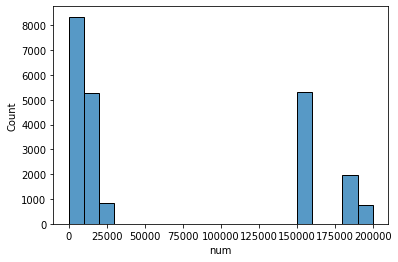

In [8]:
import datetime
import dask.dataframe as dd
import re

def read_vc():
    d = dd.read_csv(f'{DATASETS_PATH}/vcru*.csv', dtype={'comments_num': 'object'}).compute()
    d = d.drop(columns='web-scraper-order')
    d = d.rename(columns={'web-scraper-start-url':'index'}).set_index('index')
    #d.views_num = d.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))
    d = d.drop_duplicates(keep='last')
    months = ['янв', 'фев', 'мар', 'апр', 'мая', 'июн', 'июл', 'авг', 'сен', 'окт', 'ноя', 'дек']
    #d['post_time'] = pd.to_datetime(d['post_time'].apply(lambda x: x.split()[2] + '-' + str(months.index(x.split()[1])+1)+ '-' + x.split()[0]))
    #d['parse_time'] = pd.to_datetime('today').date()
    d['source'] = 'vc'
    d['num'] = d.index.map(lambda x: int(x.split('/')[-1]))
    sns.histplot(d.num)
    d = d.drop(columns='num')
    return d

d = read_vc()
d

Когда есть полные дубликаты заголовков, оставлять тот, что имеет больше просмотров.

In [55]:
def rus_date_str_to_datetime(s):
    months = ['янв', 'фев', 'мар',
              'апр', 'мая', 'июн',
              'июл', 'авг', 'сен',
              'окт', 'ноя', 'дек']
    
    s = s.replace(',', '')
    s = s.split()
    for month in months:
        i = s[1].find(month)
        if i != -1:
            break
               
    month = months.index(month)+1
    s[1] = str(month)
    if len(s) == 3:
        s.insert(2, '2021')
    s = " ".join(s)
    return s

pd.to_datetime()

'8 6 2021 22:11'

In [58]:
def read_dou():
    d = pd.read_csv(f'{DATASETS_PATH}/dou.csv')
    d = d.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
    d = d.rename(columns={'title-href':'index'}).set_index('index')
    d.views_num = d.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))
    d = d.drop_duplicates(keep='last')
    d['post_time'] = pd.to_datetime(d['post_time'].apply(rus_date_str_to_datetime))
    d['parse_time'] = pd.to_datetime('today').date()
    d['lang'] = d.apply(lambda x: detect(x.title + x.summary), axis=1)
    d = d[d.lang == 'ru'].drop(columns=['lang'])
    d['source'] = 'dou'
    return d

read_dou()

,title,summary,post_time,views_num,parse_time,source
index,,,,,,
https://dou.ua/lenta/digests/raznyie-ssyilki/,Разные ссылки,Разные ссылки: блоги Рунета популярны среди ИТ...,2007-08-06 22:11:00,20,2021-04-20,dou
https://dou.ua/lenta/digests/net-digest-20/,.NET дайджест #20: как устроена аутентификация...,В выпуске: статьи о внутренностях managed объе...,2017-07-10 10:00:00,8943,2021-04-20,dou
https://dou.ua/lenta/digests/weekly-linkdump-119/,Weekly linkdump #119,Интересные ссылки за неделю: подкаст о веб-раз...,2008-03-28 10:00:00,38,2021-04-20,dou
https://dou.ua/lenta/digests/qa-digest-21/,"QA Дайджест #21: Немного о Jmeter, о языке авт...","В выпуске: анализ «Black box» тестирования, на...",2016-02-09 10:00:00,18775,2021-04-20,dou
https://dou.ua/lenta/digests/weekly-linkdump-203/,Интересные ссылки № 203,Интересные ссылки за неделю: How To Safely Sto...,2010-05-02 12:30:00,76,2021-04-20,dou
...,...,...,...,...,...,...
https://dou.ua/lenta/interviews/viktor-nesytov-playtech-interview/,"Виктор Несытов, Playtech: «Качество киевских с...","Так уж сложилось, что основную часть украинско...",2012-12-03 14:48:00,13375,2021-04-20,dou
https://dou.ua/lenta/columns/stroim-gejm-studio-o-motivacii-i-profit-sharing/,Строим гейм студио: О мотивации и profit sharing,Наша программа Profit Sharing вызывает много в...,2011-01-06 14:40:00,5532,2021-04-20,dou
https://dou.ua/lenta/digests/pm-digest-8/,PM дайджест #8: гид по подготовке к ретроспект...,"В выпуске: 22 типа проектных рисков, как визуа...",2017-12-16 10:00:00,7849,2021-04-20,dou


In [75]:
write_df(pd.concat([df, d]))

Main datafame is saved.


In [62]:
from langdetect import detect

In [63]:
d = read_dou()

,title,summary,post_time,views_num,parse_time,source
index,,,,,,
https://dou.ua/lenta/digests/raznyie-ssyilki/,Разные ссылки,Разные ссылки: блоги Рунета популярны среди ИТ...,2007-08-06 22:11:00,20,2021-04-20,dou
https://dou.ua/lenta/digests/net-digest-20/,.NET дайджест #20: как устроена аутентификация...,В выпуске: статьи о внутренностях managed объе...,2017-07-10 10:00:00,8943,2021-04-20,dou
https://dou.ua/lenta/digests/weekly-linkdump-119/,Weekly linkdump #119,Интересные ссылки за неделю: подкаст о веб-раз...,2008-03-28 10:00:00,38,2021-04-20,dou
https://dou.ua/lenta/digests/qa-digest-21/,"QA Дайджест #21: Немного о Jmeter, о языке авт...","В выпуске: анализ «Black box» тестирования, на...",2016-02-09 10:00:00,18775,2021-04-20,dou
https://dou.ua/lenta/digests/weekly-linkdump-203/,Интересные ссылки № 203,Интересные ссылки за неделю: How To Safely Sto...,2010-05-02 12:30:00,76,2021-04-20,dou
...,...,...,...,...,...,...
https://dou.ua/lenta/interviews/viktor-nesytov-playtech-interview/,"Виктор Несытов, Playtech: «Качество киевских с...","Так уж сложилось, что основную часть украинско...",2012-12-03 14:48:00,13375,2021-04-20,dou
https://dou.ua/lenta/columns/stroim-gejm-studio-o-motivacii-i-profit-sharing/,Строим гейм студио: О мотивации и profit sharing,Наша программа Profit Sharing вызывает много в...,2011-01-06 14:40:00,5532,2021-04-20,dou
https://dou.ua/lenta/digests/pm-digest-8/,PM дайджест #8: гид по подготовке к ретроспект...,"В выпуске: 22 типа проектных рисков, как визуа...",2017-12-16 10:00:00,7849,2021-04-20,dou


In [481]:
write_df(df)

Main datafame is saved.


## 2. ML Correction of Underestimated Number of Views
The number of views on sites sometimes significantly lags behind the expected or is not always calculated correctly. For example, for new articles, or articles that changed the publicity status. This is especially noticeable when the number of views is less than the number of likes and bookmarks. To correct such values, we build a simple SGD regression model on data we can trust. Next, we extrapolate the result to "suspicious" data.

- В обучении нужно учитывать ресурс - для разных источников разная склонность к 
- Вместо разницы с текущем временем корректнее использовать дату парсинга

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

df['post_time'] = pd.to_datetime(df['post_time'], utc=True)
df['mln_secs_to_now'] = (pd.Timestamp.now(tz='UTC') - df['post_time']).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num']].dropna()
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]
df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])
df.update(df_tmp)

## 3. Target Variable Conversion: Views to Rating

Let's create datasets with the minimum required set of columns, corresponding for each model:

model | title | summary | views_num
--- | --- | --- | ---
`best_title` | `True` | `False` | `True`
`best_title_summary` | `True` | `True` | `True`

In the dataset for the title model and the summary model, the differences will be in more than just one column. Posts with the same name can have different descriptions. In such cases, in the title rating dataset, we take the number of views for the least viewed post, assuming that a short description increases engagement but does not degrade it.

Now we will sort the articles by the number of views and set each position in the top 20% to 1, and for the rest – 0. So the closer the classification score to 1, the more likely the article will receive more views.

In [ ]:
df.title[df.title.duplicated()]

In [109]:
Xy = df[['title', 'views_num']]
Xy['title'] = Xy['title'].apply(str)
#max_title_length = Xy.title.apply(len).max()
Xy.sort_values(by='views_num', inplace=True)

bound = round(Xy.shape[0]*0.2)
Xy['score'] = 0
Xy.score.iloc[-bound:] = 1
Xy['score'] = Xy['score'].astype('int8')
Xy.drop(columns='views_num', inplace=True)

In [110]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229192 entries, https://habr.com/ru/post/81826 to https://habr.com/ru/post/491974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   229192 non-null  object
 1   score   229192 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 3.7+ MB


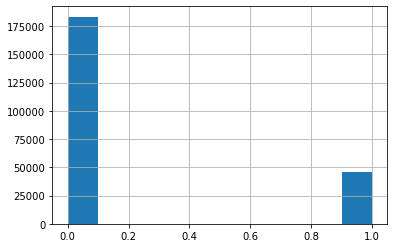

In [111]:
Xy.score.hist()

In [112]:
Xy.to_pickle('Xy.pickle', compression='gzip', protocol=4)

# XXX Archive & Drafts XXX

In [ ]:

# df['filename'] = pd.Series(df.index).apply(lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, x)))
# df_digitalocean = pd.read_csv(f'{DATASETS_PATH}/digitalocean.csv')
# df_digitalocean = df_digitalocean.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_digitalocean = df_digitalocean.set_index('title-href')
# df_digitalocean['post_time'] = pd.to_datetime(df_digitalocean['post_time'])
# df_digitalocean['parse_time'] = pd.to_datetime('today').date()
# df_digitalocean['views_num'] = df_digitalocean['views_num'].apply(lambda x: int(float(x.replace('k', 'e+3'))))
# df_digitalocean['source'] = 'digitalocean'

# df_digitalocean = df_digitalocean.reset_index()
# df_digitalocean = df_digitalocean.set_index('title-href')
# df_digitalocean.apply(lambda x: save_new_data(x.filename, x.source, x.full_text), axis=1)

# import uuid

# def save_new_data(filename, source, full_text):
#     '''Сохраняет новые данные в датафрейм, а текст -- в отдельный файл'''
#     filepath = f"{DATASETS_PATH}/{source}/{filename}"
#     if not os.path.exists(filepath):
#         with open(filepath, 'w') as f:
#             full_text = re.sub('\n+', '\n\n', full_text).strip()
#             f.write(full_text)
#     else:
#         pass

# парсинг сайтов с помощью расширения web scrapy
# def filter_df(df):
#     # drop all non-digit symbols in views of num
#     df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))



# import datetime

# df_tmp = pd.read_csv(f'{DATASETS_PATH}/xakep.csv')
# df_tmp = df_tmp.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_tmp = df_tmp.set_index('title-href')
# #df_tmp = df_tmp.fillna(0)

# def find_digit(s):
#     digit_string = re.findall(r'\d+', s)
#     if digit_string:
#         return int(digit_string[0])
#     else:
#         return 0

# df_tmp.comments_num = df_tmp.comments_num.apply(find_digit)
# df_tmp['parse_time'] = datetime.datetime.now()
# df_tmp['comments_num'] = df_tmp['comments_num'].replace('Обсудить', '0')
# df_tmp['comments_num'] = df_tmp['comments_num'].astype('int8')
# df_tmp['likes_num'] = df_tmp['likes_num'].astype('int8')
# df_tmp['favs_num'] = df_tmp['favs_num'].astype('int8')
# df_tmp.set_index('url-href').to_csv(f'{DATASETS_PATH}/thecode.csv')

In [ ]:
# def filename(x):
#     return str(uuid.uuid5(uuid.NAMESPACE_DNS, x))

# генерация дополнительных признаков
# Xy.loc[:, ['title']] = Xy.title.apply(str)

# Xy.loc[:, ['doc']] = Xy.title.progress_apply(nlp)

# длина заголовка в символах
# Xy.loc[:, ['len']] = Xy.title.apply(len)

# количество токенов
# Xy.loc[:, ['tokens_num']] = Xy.tokens.apply(lambda x: len(x))

# Токенизация большого числа заголовков — затратная по времени операция.
# Поэтому предварительно токенизированные заголовки хранятся в виде
# сжатого датафрайма
#tokenized_titles = pd.read_pickle(TOKENIZED_TITLES_PATH, compression='gzip')

# for i in [3, 8, 9]:
#     spacy.displacy.render(tokenized_titles.iloc[i], style='ent', jupyter=True)

# tokenized_titles.to_pickle(path=TOKENIZED_TITLES_PATH, compression='gzip')

# def proglib_cleaner(s):
#     s = re.sub('[ \t]+', ' ', s)
#     s = re.sub('\n ', '\n', s)
#     s = re.sub('\n+', '\n', s)
#     s = re.sub('\n', '\n\n', s)
#     s = re.sub('Библиотека программиста\n\n|Закрепить\n\n|Изменить\n\n|Удалить\n\n|', '', s)
#     s = '\n\n'.join(s.split('\n\n')[7:-5])
#     return s